# Reading Sentinel 1 features through STAC

In [4]:
from datetime import datetime
import os

import boto3
from dotenv import load_dotenv
import geopandas as gpd
from pystac_client import Client
import matplotlib.pyplot as plt
import numpy as np
from rasterio.enums import Resampling
from rasterio.session import AWSSession
import rioxarray
import stackstac

## Input

Authentication

In [5]:
auth_method = "profile"
endpoint_url = "s3.waw3-1.cloudferro.com"
if auth_method == "profile":
    profile = "lcfm"
else:
    # Read s3 keys from .env files
    load_dotenv()
    os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
    os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

Query

In [6]:
shapefile = "./29TNE_shape.geojson"
crs = 32629

# Read 29TNE_shape.geojson
gdf = gpd.read_file(shapefile).to_crs(32629)
bounds = gdf.iloc[0].geometry.bounds
geometry_latlon = gdf.to_crs("EPSG:4326").geometry.iloc[0]

Collection parameters

In [7]:
collection = "LCFM_LSF-ANNUAL-S1_v100"
resolution = 20

In [8]:
# Define the date range for the search
year = 2020
start_date = datetime(year, 1, 1).isoformat() + "Z"
end_date = datetime(year, 12, 12).isoformat() + "Z"

## STAC query

In [9]:
# Connect to the STAC API
stac_api_url = "https://www.stac.lcfm.dataspace.copernicus.eu/"
catalog = Client.open(stac_api_url)

# Fetch items from the collection using the search method with spatial and temporal constraints
search = catalog.search(
    collections=[collection],
    datetime=f"{start_date}/{end_date}",
    intersects=geometry_latlon,
)

items = list(search.items())[::-1]

if items:
    print(f"Sample item found in the collection: {items[0].id}")
else:
    print("No items found in the collection.")


Sample item found in the collection: LCFM_LSF-ANNUAL-S1_V100_2020_29TNE


In [10]:
# S3 session info
# If profile, pass profile_name; otherwise use keys
if auth_method == "profile":
    b3 = boto3.Session(profile_name="lcfm")
else:
    b3 = boto3.Session(
        aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    )

aws_session = AWSSession(session=b3, endpoint_url=endpoint_url)

# 3) Tell GDAL to use path-style + your endpoint
gdal_env = stackstac.DEFAULT_GDAL_ENV.updated(
    always={
      "session":                 aws_session,
    }
)

## NB OBs

In [11]:
# Assuming 'items' is a list of STAC items you've retrieved
item = items[0]  # Using the first item for this example
assets = ["GAMMA0-OBS-NB"]

# Now you can use stackstac with the modified STAC item
s1_obs = stackstac.stack([item],
                          assets=assets,
                          bounds=bounds,
                          resolution=resolution,
                          epsg=crs,
                          fill_value=np.uint8(255),
                          dtype=np.uint8,
                          rescale=False,
                          gdal_env=gdal_env,
                          )

# Example to check the DataArray information
# s1_obs

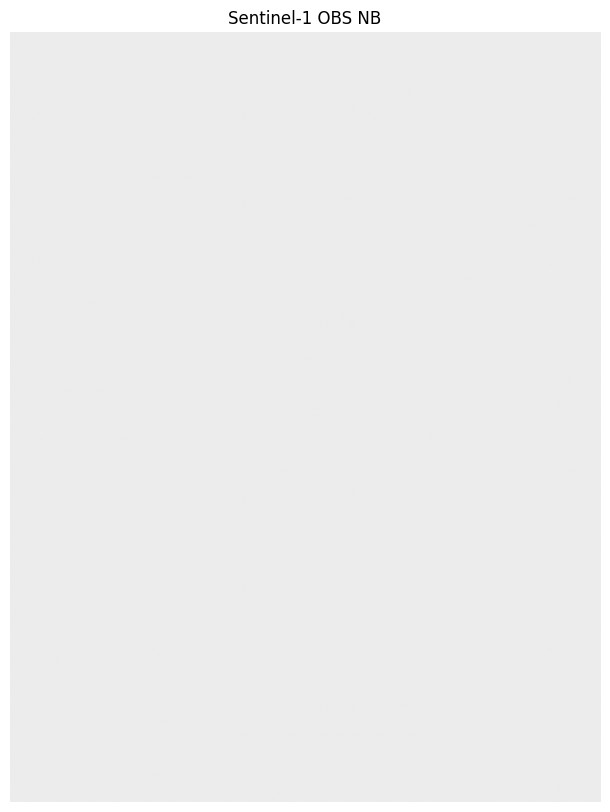

In [12]:
# Extract the bands (assuming the order is B04=0, B03=1, B02=2)
obs_nb = s1_obs.sel(band="GAMMA0-OBS-NB").values[0,:,:]

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(obs_nb, cmap='gray', vmin=0, vmax=13)  # Use 'gray' for single band
plt.title("Sentinel-1 OBS NB")
plt.axis('off')  # Hide the axis
plt.show()

In [13]:
# Write out
profile_kwargs = {
    "driver": "GTiff",
    "dtype": str(s1_obs.dtype),     # make sure your data actually fits this type
    "compress": "LZW",    # lossless LZW compression
}

output_file = "s1_data.tif"
s1_obs.name = s1_obs.band.values[0]
s1_obs.isel(time=0).rio.to_raster(output_file, **profile_kwargs)

print(f"Saved GeoTIFF → {output_file}")

Saved GeoTIFF → s1_data.tif


### Reproject

In [14]:
# reproject
obs_nb_wgs84 = s1_obs.isel(time=0).rio.reproject(
    "EPSG:4326",              # target CRS
    resolution=2*8.33333e-5,       # lon/lat degrees per pixel
    resampling=Resampling.bilinear     # or "nearest", "cubic", etc.
)

In [15]:
# Write out
profile_kwargs = {
    "driver": "GTiff",
    "dtype": str(obs_nb_wgs84.dtype),     # make sure your data actually fits this type
    "compress": "LZW",    # lossless LZW compression
}

output_file = "s1_data_4326.tif"
obs_nb_wgs84.name = obs_nb_wgs84.band.values[0]
obs_nb_wgs84.rio.to_raster(output_file, **profile_kwargs)

print(f"Saved GeoTIFF → {output_file}")

Saved GeoTIFF → s1_data_4326.tif


## P50

In [16]:
# Assuming 'items' is a list of STAC items you've retrieved
item = items[0]  # Using the first item for this example
assets = ["GAMMA0-VV-P50", "GAMMA0-VH-P50", "GAMMA0-VHVVRATIO-P50"]

# Now you can use stackstac with the modified STAC item
s1_data = stackstac.stack([item],
                          assets=assets,
                          bounds=bounds,
                          resolution=resolution,
                          epsg=crs,
                          fill_value=np.uint16(65535),
                          dtype=np.uint16,
                          rescale=False,
                          gdal_env=gdal_env,
                          )

# Example to check the DataArray information
# s1_data

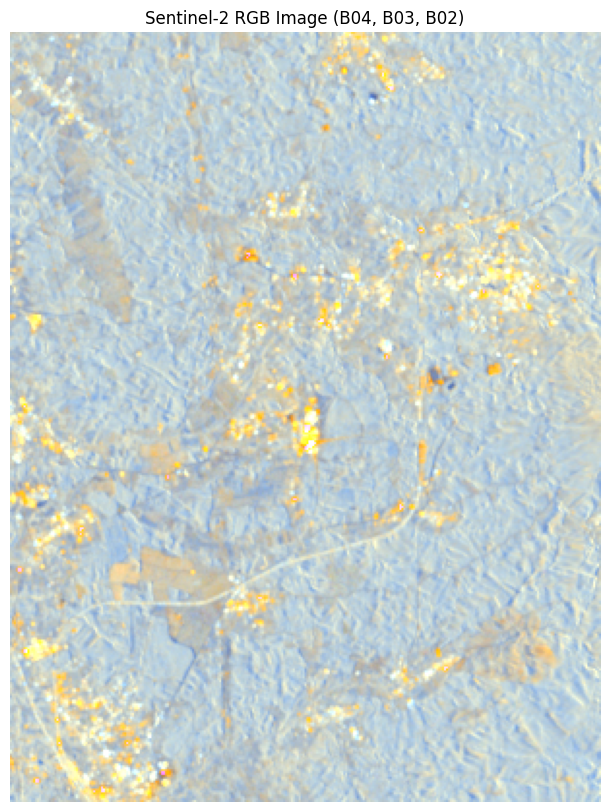

In [17]:
# Normalize the data (assuming values are reflectance between 0 and 1, or you can scale accordingly)
def normalize(array, array_min=None, array_max=None):
    """ Normalize array values to the 0-1 range for display """
    if array_min is None or array_max is None:
        array_min, array_max = np.nanmin(array), np.nanmax(array)
    normaized_array = (array - array_min) / (array_max - array_min)
    return normaized_array.clip(0, 1)

# Extract the bands (assuming the order is B04=0, B03=1, B02=2)
red_band = s1_data.sel(band="GAMMA0-VV-P50").values
green_band = s1_data.sel(band="GAMMA0-VH-P50").values
blue_band = s1_data.sel(band="GAMMA0-VHVVRATIO-P50").values

# Normalize each band
red_normalized = normalize(red_band, array_min=22000, array_max=40000)[0,:,:]
green_normalized = normalize(green_band, array_min=10000, array_max=35000)[0,:,:]
blue_normalized = normalize(blue_band, array_min=29000, array_max=42000)[0,:,:]

# Stack the bands into an RGB image
rgb_image = np.dstack((red_normalized, green_normalized, blue_normalized))

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title("Sentinel-2 RGB Image (B04, B03, B02)")
plt.axis('off')  # Hide the axis
plt.show()